# TrainingTransferMulti
Entrainement des modèles de transfer learning DenseNet201 13 bandes pour café contre reste et culture contre non-culture

* Romain Capocasale
* IADeforestation
* HES-SO MASTER

# Import

In [1]:
import os
import random
import numpy as np
import rasterio
import matplotlib.pyplot as plt 
import pandas as pd
import statistics
import seaborn as sn
import json
import geopandas as gpd
import spacv

from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, f1_score, classification_report

from tensorflow.python.client import device_lib
from tensorflow.keras.models import Model, load_model, model_from_json
from tensorflow.keras.applications.densenet import DenseNet201 as DenseNet
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Flatten, Dropout, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras import metrics
from focal_loss import BinaryFocalLoss
from keras import backend as K 
from shapely import wkt

from IAdeforestation.preprocessing import *
from IAdeforestation.training import *
from IAdeforestation.tools import *
from IAdeforestation.spatial_cross_val import * 

/home/romain.capocasa/romain_env/lib/python3.8/site-packages/geopandas/_compat.py:106: UserWarning: The Shapely GEOS version (3.8.0-CAPI-1.13.1 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(


In [2]:
print(device_lib.list_local_devices())

K.clear_session()

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2541198150621580106
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7783953216
locality {
  bus_id: 1
  links {
  }
}
incarnation: 10426113085661628745
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
SAVED_MODELS_PATH = os.path.join('saved_models', 'transfer_learning')
SAVED_DATASET_PATH = "datasets"
vietnam = gpd.read_file(os.path.join("district","diaphanhuyen.shp"))

# Load base model

In [5]:
source_model = load_model("transfer_learning_model/dense_ms_from_scratch.209-0.990.hdf5", compile=False)
source_model.trainable = False

### Uncomment above line for 32x32 images

In [6]:
#source_model = change_model(source_model, new_input_shape=(None, 32,32,13),custom_objects={'LeakyReLU':LeakyReLU})

In [7]:
source_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 64, 64, 13)] 0                                            
__________________________________________________________________________________________________
zero_padding2d_6 (ZeroPadding2D (None, 70, 70, 13)   0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 32, 32, 64)   40768       zero_padding2d_6[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 32, 32, 64)   256         conv1/conv[0][0]                 
____________________________________________________________________________________________

In [8]:
def create_model():
    # Add new layer to pre-trained network
    flat1 = Flatten()(source_model.layers[-3].output)
    dropout_flatten = Dropout(0.5)(flat1)

    dense256 = Dense(128, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001))(dropout_flatten)
    dropout256 = Dropout(0.5)(dense256)

    dense32 = Dense(32, activation=LeakyReLU(), kernel_regularizer=regularizers.l2(0.001))(dropout256)
    dropout32 = Dropout(0.5)(dense32)

    output = Dense(1, activation='sigmoid')(dropout32)

    return Model(inputs=source_model.input, outputs=output)

# Coffee vs other
## Spatial Cross val

In [12]:
train_data = gpd.GeoDataFrame(pd.read_csv(os.path.join('datasets', 'coffee_10fold', 'train_data.csv')))
train_data['geometry'] = train_data['geometry'].apply(wkt.loads)

### Compute class weight

In [13]:
nb_0 = len(train_data[train_data['label']==0])
nb_1 = len(train_data[train_data['label']==1])
total = nb_0 + nb_1

weight_for_0 = (1 / nb_0)*(total)/2.0 
weight_for_1 = (1 / nb_1)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

In [14]:
nb_labels = train_data['label'].value_counts().to_dict()
prop0 = nb_labels[0]/(nb_labels[0]+nb_labels[1])
prop1 = nb_labels[1]/(nb_labels[0]+nb_labels[1])

print(prop0)
print(prop1)

0.2469879518072289
0.7530120481927711


### Train model

In [18]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 3
RUN_NAME = 'final_spacv_10FOLD_coffee_1'

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME))
    
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      f1_score_keras
]

results = []

Fold 1 Number coffee - train : 316
Fold 1 Number no-coffee - train : 1063
Fold 1 Number coffee - val : 94
Fold 1 Number no-coffee - val : 187
Training for fold 1
-----
Epoch 1/100
63/63 [==============================] - 19s 166ms/step - loss: 1.0185 - accuracy: 0.5205 - precision: 0.7554 - recall: 0.5549 - f1_score_keras: 0.6377 - val_loss: 0.9394 - val_accuracy: 0.6484 - val_precision: 0.6995 - val_recall: 0.8514 - val_f1_score_keras: 0.7677
Epoch 2/100
63/63 [==============================] - 8s 126ms/step - loss: 0.9320 - accuracy: 0.6508 - precision: 0.8020 - recall: 0.7281 - f1_score_keras: 0.7615 - val_loss: 0.9440 - val_accuracy: 0.6055 - val_precision: 0.6619 - val_recall: 0.8225 - val_f1_score_keras: 0.7325
Epoch 3/100
63/63 [==============================] - 8s 124ms/step - loss: 0.8939 - accuracy: 0.6967 - precision: 0.8253 - recall: 0.7670 - f1_score_keras: 0.7938 - val_loss: 0.9333 - val_accuracy: 0.5938 - val_precision: 0.6667 - val_recall: 0.7545 - val_f1_score_keras: 0

Epoch 30/100
63/63 [==============================] - 8s 131ms/step - loss: 0.4953 - accuracy: 0.8613 - precision: 0.9612 - recall: 0.8539 - f1_score_keras: 0.9035 - val_loss: 1.0462 - val_accuracy: 0.5352 - val_precision: 0.6960 - val_recall: 0.5179 - val_f1_score_keras: 0.5932
Epoch 31/100
63/63 [==============================] - 8s 130ms/step - loss: 0.4693 - accuracy: 0.8689 - precision: 0.9656 - recall: 0.8598 - f1_score_keras: 0.9087 - val_loss: 1.0206 - val_accuracy: 0.5430 - val_precision: 0.6780 - val_recall: 0.5031 - val_f1_score_keras: 0.5739
Epoch 32/100
63/63 [==============================] - 8s 131ms/step - loss: 0.4823 - accuracy: 0.8657 - precision: 0.9648 - recall: 0.8564 - f1_score_keras: 0.9067 - val_loss: 0.9796 - val_accuracy: 0.5664 - val_precision: 0.7557 - val_recall: 0.5562 - val_f1_score_keras: 0.6394
Epoch 33/100
63/63 [==============================] - 8s 133ms/step - loss: 0.4596 - accuracy: 0.8665 - precision: 0.9692 - recall: 0.8531 - f1_score_keras: 0.9

63/63 [==============================] - 8s 128ms/step - loss: 0.4031 - accuracy: 0.8934 - precision: 0.9591 - recall: 0.8982 - f1_score_keras: 0.9259 - val_loss: 1.0517 - val_accuracy: 0.6094 - val_precision: 0.6978 - val_recall: 0.6258 - val_f1_score_keras: 0.6586
Epoch 89/100
63/63 [==============================] - 8s 129ms/step - loss: 0.3607 - accuracy: 0.9117 - precision: 0.9769 - recall: 0.9068 - f1_score_keras: 0.9405 - val_loss: 1.2132 - val_accuracy: 0.5820 - val_precision: 0.7391 - val_recall: 0.5896 - val_f1_score_keras: 0.6519
Epoch 90/100
63/63 [==============================] - 8s 131ms/step - loss: 0.3708 - accuracy: 0.9035 - precision: 0.9716 - recall: 0.9004 - f1_score_keras: 0.9339 - val_loss: 1.1053 - val_accuracy: 0.6133 - val_precision: 0.7007 - val_recall: 0.6519 - val_f1_score_keras: 0.6759
Epoch 91/100
63/63 [==============================] - 8s 126ms/step - loss: 0.3584 - accuracy: 0.9070 - precision: 0.9724 - recall: 0.9035 - f1_score_keras: 0.9366 - val_los

Epoch 14/100
60/60 [==============================] - 8s 128ms/step - loss: 0.6919 - accuracy: 0.7346 - precision: 0.9351 - recall: 0.6812 - f1_score_keras: 0.7861 - val_loss: 0.7430 - val_accuracy: 0.6656 - val_precision: 0.9788 - val_recall: 0.6424 - val_f1_score_keras: 0.7750
Epoch 15/100
60/60 [==============================] - 8s 131ms/step - loss: 0.6857 - accuracy: 0.7389 - precision: 0.9325 - recall: 0.6832 - f1_score_keras: 0.7860 - val_loss: 0.7422 - val_accuracy: 0.6406 - val_precision: 0.9735 - val_recall: 0.6259 - val_f1_score_keras: 0.7605
Epoch 16/100
60/60 [==============================] - 8s 131ms/step - loss: 0.6739 - accuracy: 0.7571 - precision: 0.9338 - recall: 0.7065 - f1_score_keras: 0.8030 - val_loss: 0.7536 - val_accuracy: 0.6250 - val_precision: 0.9884 - val_recall: 0.5917 - val_f1_score_keras: 0.7363
Epoch 17/100
60/60 [==============================] - 8s 132ms/step - loss: 0.6525 - accuracy: 0.7572 - precision: 0.9475 - recall: 0.6951 - f1_score_keras: 0.8

Epoch 3/100
63/63 [==============================] - 8s 124ms/step - loss: 0.8660 - accuracy: 0.6870 - precision: 0.8374 - recall: 0.7505 - f1_score_keras: 0.7897 - val_loss: 0.8338 - val_accuracy: 0.7109 - val_precision: 0.6881 - val_recall: 0.9267 - val_f1_score_keras: 0.7888
Epoch 4/100
63/63 [==============================] - 8s 129ms/step - loss: 0.8312 - accuracy: 0.7239 - precision: 0.8607 - recall: 0.7765 - f1_score_keras: 0.8148 - val_loss: 0.7774 - val_accuracy: 0.7695 - val_precision: 0.7660 - val_recall: 0.9057 - val_f1_score_keras: 0.8299
Epoch 5/100
63/63 [==============================] - 8s 125ms/step - loss: 0.8175 - accuracy: 0.7265 - precision: 0.8622 - recall: 0.7735 - f1_score_keras: 0.8140 - val_loss: 0.7712 - val_accuracy: 0.7852 - val_precision: 0.7836 - val_recall: 0.8816 - val_f1_score_keras: 0.8312
Epoch 6/100
63/63 [==============================] - 8s 129ms/step - loss: 0.8004 - accuracy: 0.7225 - precision: 0.8738 - recall: 0.7455 - f1_score_keras: 0.8028 

63/63 [==============================] - 8s 129ms/step - loss: 0.4333 - accuracy: 0.8496 - precision: 0.9610 - recall: 0.8449 - f1_score_keras: 0.8985 - val_loss: 0.4428 - val_accuracy: 0.8711 - val_precision: 0.8471 - val_recall: 0.9536 - val_f1_score_keras: 0.8970
Epoch 62/100
63/63 [==============================] - 8s 125ms/step - loss: 0.4333 - accuracy: 0.8586 - precision: 0.9585 - recall: 0.8583 - f1_score_keras: 0.9054 - val_loss: 0.4347 - val_accuracy: 0.8477 - val_precision: 0.8722 - val_recall: 0.9075 - val_f1_score_keras: 0.8888
Epoch 63/100
63/63 [==============================] - 8s 128ms/step - loss: 0.4460 - accuracy: 0.8593 - precision: 0.9589 - recall: 0.8607 - f1_score_keras: 0.9070 - val_loss: 0.4397 - val_accuracy: 0.8555 - val_precision: 0.8529 - val_recall: 0.9236 - val_f1_score_keras: 0.8849
Epoch 64/100
63/63 [==============================] - 8s 129ms/step - loss: 0.4577 - accuracy: 0.8616 - precision: 0.9526 - recall: 0.8693 - f1_score_keras: 0.9083 - val_los

Epoch 16/100
51/51 [==============================] - 7s 134ms/step - loss: 0.7417 - accuracy: 0.7152 - precision: 0.9012 - recall: 0.7002 - f1_score_keras: 0.7861 - val_loss: 0.5454 - val_accuracy: 0.8672 - val_precision: 0.9429 - val_recall: 0.8807 - val_f1_score_keras: 0.9096
Epoch 17/100
51/51 [==============================] - 7s 139ms/step - loss: 0.7451 - accuracy: 0.7125 - precision: 0.9031 - recall: 0.6846 - f1_score_keras: 0.7767 - val_loss: 0.5045 - val_accuracy: 0.8730 - val_precision: 0.9621 - val_recall: 0.8744 - val_f1_score_keras: 0.9160
Epoch 18/100
51/51 [==============================] - 7s 139ms/step - loss: 0.7157 - accuracy: 0.7205 - precision: 0.9120 - recall: 0.6957 - f1_score_keras: 0.7876 - val_loss: 0.5100 - val_accuracy: 0.8789 - val_precision: 0.9570 - val_recall: 0.8766 - val_f1_score_keras: 0.9145
Epoch 19/100
51/51 [==============================] - 7s 136ms/step - loss: 0.7194 - accuracy: 0.7256 - precision: 0.9079 - recall: 0.7024 - f1_score_keras: 0.7

51/51 [==============================] - 7s 142ms/step - loss: 0.4787 - accuracy: 0.8418 - precision: 0.9470 - recall: 0.8335 - f1_score_keras: 0.8857 - val_loss: 0.4713 - val_accuracy: 0.8477 - val_precision: 0.9571 - val_recall: 0.8417 - val_f1_score_keras: 0.8951
Epoch 75/100
51/51 [==============================] - 7s 136ms/step - loss: 0.4897 - accuracy: 0.8388 - precision: 0.9392 - recall: 0.8399 - f1_score_keras: 0.8861 - val_loss: 0.4555 - val_accuracy: 0.8574 - val_precision: 0.9563 - val_recall: 0.8497 - val_f1_score_keras: 0.9001
Epoch 76/100
51/51 [==============================] - 7s 138ms/step - loss: 0.4917 - accuracy: 0.8253 - precision: 0.9481 - recall: 0.8068 - f1_score_keras: 0.8706 - val_loss: 0.4249 - val_accuracy: 0.8770 - val_precision: 0.9662 - val_recall: 0.8706 - val_f1_score_keras: 0.9157
Epoch 77/100
51/51 [==============================] - 7s 138ms/step - loss: 0.4930 - accuracy: 0.8508 - precision: 0.9416 - recall: 0.8465 - f1_score_keras: 0.8903 - val_los

Fold 5 Number coffee - train : 374
Fold 5 Number no-coffee - train : 1138
Fold 5 Number coffee - val : 36
Fold 5 Number no-coffee - val : 112
Training for fold 5
-----
Epoch 1/100
69/69 [==============================] - 17s 152ms/step - loss: 1.0382 - accuracy: 0.6045 - precision: 0.8132 - recall: 0.6228 - f1_score_keras: 0.6068 - val_loss: 0.9670 - val_accuracy: 0.6250 - val_precision: 0.7374 - val_recall: 0.7684 - val_f1_score_keras: 0.7517
Epoch 2/100
69/69 [==============================] - 8s 124ms/step - loss: 0.9351 - accuracy: 0.6453 - precision: 0.8046 - recall: 0.7073 - f1_score_keras: 0.7517 - val_loss: 0.9823 - val_accuracy: 0.4609 - val_precision: 0.6386 - val_recall: 0.5761 - val_f1_score_keras: 0.6049
Epoch 3/100
69/69 [==============================] - 8s 120ms/step - loss: 0.9178 - accuracy: 0.6655 - precision: 0.8060 - recall: 0.7306 - f1_score_keras: 0.7644 - val_loss: 0.9779 - val_accuracy: 0.3594 - val_precision: 0.6271 - val_recall: 0.3814 - val_f1_score_keras: 0

Epoch 30/100
69/69 [==============================] - 8s 121ms/step - loss: 0.5133 - accuracy: 0.8433 - precision: 0.9581 - recall: 0.8300 - f1_score_keras: 0.8887 - val_loss: 0.9462 - val_accuracy: 0.4297 - val_precision: 0.8571 - val_recall: 0.3061 - val_f1_score_keras: 0.4491
Epoch 31/100
69/69 [==============================] - 8s 121ms/step - loss: 0.5188 - accuracy: 0.8308 - precision: 0.9541 - recall: 0.8113 - f1_score_keras: 0.8755 - val_loss: 0.9247 - val_accuracy: 0.4609 - val_precision: 0.8085 - val_recall: 0.3878 - val_f1_score_keras: 0.5229
Epoch 32/100
69/69 [==============================] - 8s 120ms/step - loss: 0.5113 - accuracy: 0.8320 - precision: 0.9617 - recall: 0.8121 - f1_score_keras: 0.8799 - val_loss: 0.9517 - val_accuracy: 0.4297 - val_precision: 0.8500 - val_recall: 0.3366 - val_f1_score_keras: 0.4817
Epoch 33/100
69/69 [==============================] - 8s 123ms/step - loss: 0.5150 - accuracy: 0.8411 - precision: 0.9516 - recall: 0.8299 - f1_score_keras: 0.8

69/69 [==============================] - 8s 120ms/step - loss: 0.3976 - accuracy: 0.8706 - precision: 0.9651 - recall: 0.8617 - f1_score_keras: 0.9085 - val_loss: 0.8931 - val_accuracy: 0.4453 - val_precision: 0.9268 - val_recall: 0.3585 - val_f1_score_keras: 0.5161
Epoch 89/100
69/69 [==============================] - 8s 118ms/step - loss: 0.4178 - accuracy: 0.8621 - precision: 0.9687 - recall: 0.8453 - f1_score_keras: 0.9018 - val_loss: 0.8745 - val_accuracy: 0.4766 - val_precision: 0.8511 - val_recall: 0.4000 - val_f1_score_keras: 0.5416
Epoch 90/100
69/69 [==============================] - 8s 122ms/step - loss: 0.4011 - accuracy: 0.8718 - precision: 0.9711 - recall: 0.8567 - f1_score_keras: 0.9089 - val_loss: 0.8608 - val_accuracy: 0.5000 - val_precision: 0.8571 - val_recall: 0.4242 - val_f1_score_keras: 0.5691
Epoch 91/100
69/69 [==============================] - 8s 119ms/step - loss: 0.4115 - accuracy: 0.8684 - precision: 0.9719 - recall: 0.8526 - f1_score_keras: 0.9079 - val_los

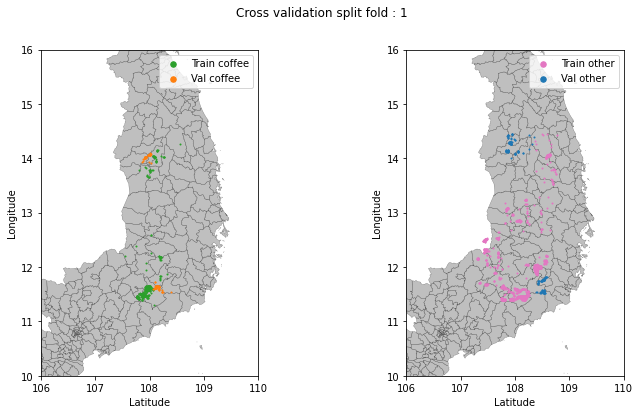

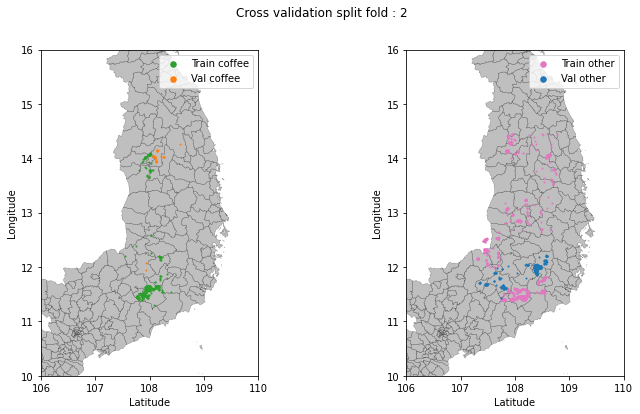

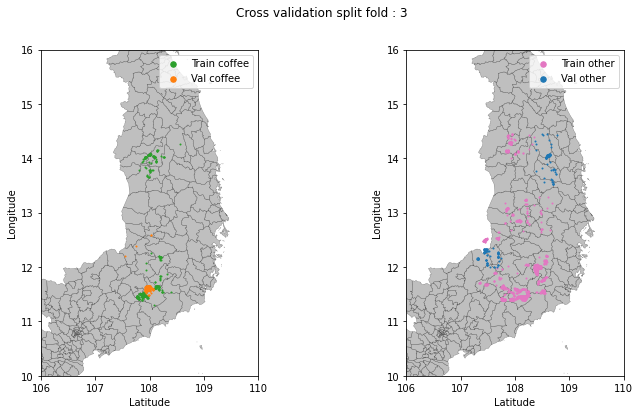

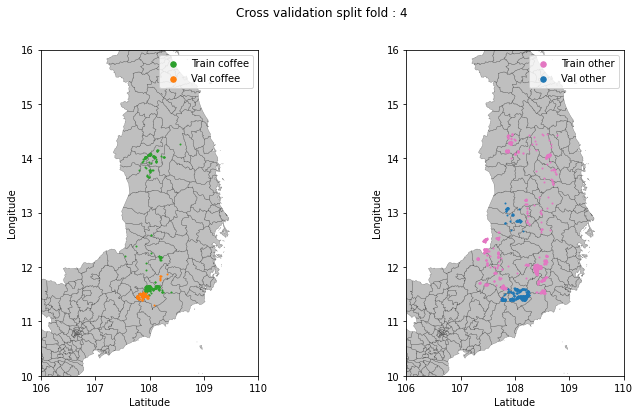

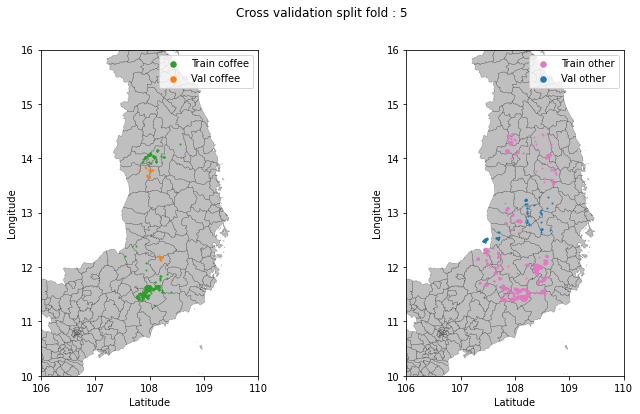

In [20]:
NB_FOLD = 5
for i_fold in range(0, NB_FOLD):
    geo_train = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","coffee_10fold",f"train_{i_fold+1}_data.csv")))
    geo_train['geometry'] = geo_train['geometry'].apply(wkt.loads)
    
    geo_val = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","coffee_10fold",f"val_{i_fold+1}_data.csv")))
    geo_val['geometry'] = geo_val['geometry'].apply(wkt.loads)

    display_cross_val_map_class(geo_train, geo_val, vietnam, f"Cross validation split fold : {i_fold+1}")
    
    print(f"Fold {i_fold+1} Number coffee - train : {len(geo_train[geo_train['label'] == 0])}")
    print(f"Fold {i_fold+1} Number no-coffee - train : {len(geo_train[geo_train['label'] == 1])}")

    print(f"Fold {i_fold+1} Number coffee - val : {len(geo_val[geo_val['label'] == 0 ])}")
    print(f"Fold {i_fold+1} Number no-coffee - val : {len(geo_val[geo_val['label'] == 1])}")
    print(f"Training for fold {i_fold+1}")

    print("-----")
    
    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                        epochs=EPOCH,
                        steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=validation_generator,
                        validation_steps=(len(geo_val)//BATCH_SIZE),
                        callbacks=[earlystopper],
                        class_weight=class_weight)

    model.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    results.append(result)

    print(f"Fold {i_fold+1} loss : {result[0]}")
    print(f"Fold {i_fold+1} accuracy : {result[1]}")
    print(f"Fold {i_fold+1} F1-score : {result[4]}")
    
    compute_score(geo_val, model)

    print("\n")

    K.clear_session()

In [20]:
with open(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

### Fold score

In [21]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.6953125
Stdev accuracy : 0.15110675680830754


Mean loss : 0.7212890923023224
Stdev loss : 0.27897950439929714


Mean precision : 0.859698748588562
Stdev precision : 0.11914386048059786


Mean recall : 0.6981595456600189
Stdev recall : 0.17213882103854306


Mean F1-Score : 0.7586449146270752
Stdev F1-Score : 0.1398202048717716


### Loss and accuracy plots per fold

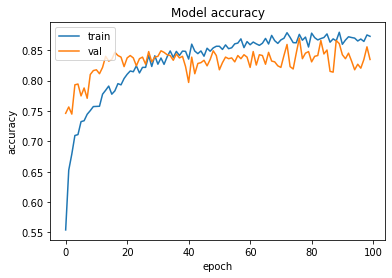

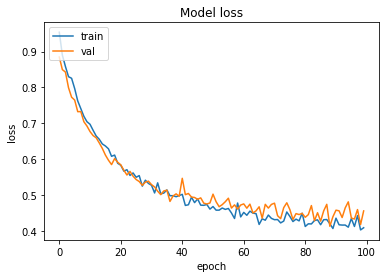

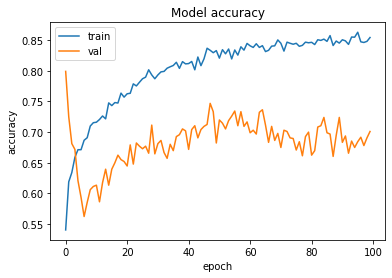

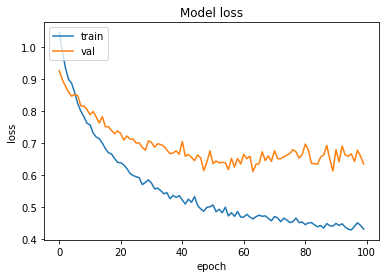

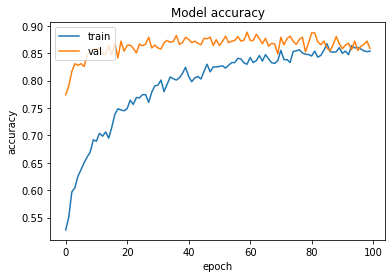

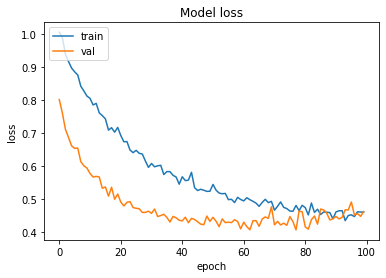

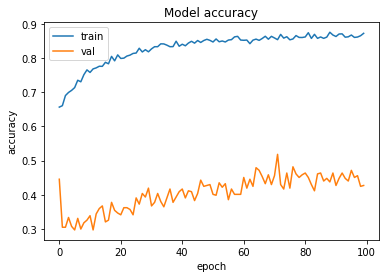

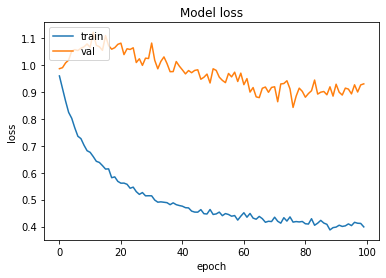

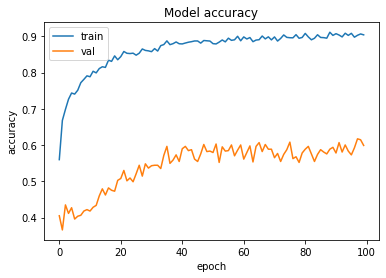

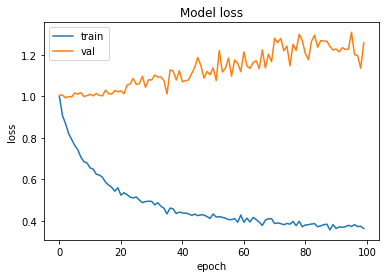

In [9]:
a = os.path.join(SAVED_MODELS_PATH, 'Coffee', 'final_spacv_10FOLD_coffee_2')
for i in os.listdir(a):
    if(i.split('.')[1] == 'npy'):
        chart = np.load(os.path.join(a, i), allow_pickle=True).item()
        
        # summarize history for accuracy
        plt.plot(chart['accuracy'])
        plt.plot(chart['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

        # summarize history for loss
        plt.plot(chart['loss'])
        plt.plot(chart['val_loss'])
        plt.title('Model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

## Stratified cross-val

In [8]:
data_train = gpd.GeoDataFrame(pd.read_csv(os.path.join( 'datasets', 'new_strat_spring_train.csv')))
data_train['geometry'] = data_train['geometry'].apply(wkt.loads)

### Compute class weight

In [9]:
nb_0 = len(data_train[data_train['label']==0])
nb_1 = len(data_train[data_train['label']==1])
total = nb_0 + nb_1

weight_for_0 = (1 / nb_0)*(total)/2.0 
weight_for_1 = (1 / nb_1)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

### Train model

In [10]:
# Params
BATCH_SIZE = 256
EPOCH = 300
LEARNING_RATE = 0.00001
DATA_AUGMENTATION_MULTIPLIATOR = 3
RUN_NAME = 'start_coffee_300E_focal_2'
NB_FOLD = 5

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME))
    
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall')
]

In [11]:

fold_index = 0

results = []

skf = StratifiedKFold(n_splits=5)
for train, validation in skf.split(data_train['path'].to_numpy(), data_train['label'].to_numpy()):
    
    geo_train = data_train.iloc[train]
    geo_val = data_train.iloc[validation]
    
    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(loss=BinaryFocalLoss(gamma=2), optimizer=Adam(learning_rate=LEARNING_RATE), metrics=METRICS)

    history = model.fit(train_generator,
                                epochs=EPOCH,
                                steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                validation_data=validation_generator,
                                validation_steps=len(geo_val)//BATCH_SIZE,
                                callbacks=[earlystopper],
                                class_weight=class_weight)

    model.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    result.append(2*((result[2]*result[3])/(result[2]+result[3])))
    results.append(result)
    
    print(f"Fold {fold_index} loss : {result[0]}")
    print(f"Fold {fold_index} accuracy : {result[1]}")
    print(f"Fold {fold_index} F1-score : {result[4]}")
    print("\n")

    K.clear_session()

    fold_index+=1
    

Epoch 1/300
15/15 [==============================] - 20s 771ms/step - loss: 0.5212 - accuracy: 0.5594 - precision: 0.7806 - recall: 0.5906 - val_loss: 0.4492 - val_accuracy: 0.7201 - val_precision: 0.8429 - val_recall: 0.7782
Epoch 2/300
15/15 [==============================] - 9s 612ms/step - loss: 0.5094 - accuracy: 0.5752 - precision: 0.7648 - recall: 0.6198 - val_loss: 0.4413 - val_accuracy: 0.7266 - val_precision: 0.8602 - val_recall: 0.7662
Epoch 3/300
15/15 [==============================] - 9s 619ms/step - loss: 0.4908 - accuracy: 0.6080 - precision: 0.7894 - recall: 0.6524 - val_loss: 0.4343 - val_accuracy: 0.7279 - val_precision: 0.8661 - val_recall: 0.7573
Epoch 4/300
15/15 [==============================] - 9s 616ms/step - loss: 0.4822 - accuracy: 0.6154 - precision: 0.8024 - recall: 0.6457 - val_loss: 0.4305 - val_accuracy: 0.7240 - val_precision: 0.9022 - val_recall: 0.7131
Epoch 5/300
15/15 [==============================] - 9s 603ms/step - loss: 0.4742 - accuracy: 0.615

15/15 [==============================] - 9s 632ms/step - loss: 0.2894 - accuracy: 0.7883 - precision: 0.9238 - recall: 0.7870 - val_loss: 0.2812 - val_accuracy: 0.7917 - val_precision: 0.9367 - val_recall: 0.7806
Epoch 74/300
15/15 [==============================] - 9s 638ms/step - loss: 0.2803 - accuracy: 0.8007 - precision: 0.9347 - recall: 0.7950 - val_loss: 0.2812 - val_accuracy: 0.7891 - val_precision: 0.9391 - val_recall: 0.7707
Epoch 75/300
15/15 [==============================] - 9s 645ms/step - loss: 0.2890 - accuracy: 0.7856 - precision: 0.9214 - recall: 0.7850 - val_loss: 0.2785 - val_accuracy: 0.8060 - val_precision: 0.9605 - val_recall: 0.7804
Epoch 76/300
15/15 [==============================] - 9s 642ms/step - loss: 0.2821 - accuracy: 0.7943 - precision: 0.9376 - recall: 0.7815 - val_loss: 0.2794 - val_accuracy: 0.7917 - val_precision: 0.9443 - val_recall: 0.7750
Epoch 77/300
15/15 [==============================] - 9s 620ms/step - loss: 0.2825 - accuracy: 0.7974 - preci

15/15 [==============================] - 9s 639ms/step - loss: 0.2284 - accuracy: 0.8001 - precision: 0.9350 - recall: 0.7915 - val_loss: 0.2215 - val_accuracy: 0.8125 - val_precision: 0.9478 - val_recall: 0.7923
Epoch 146/300
15/15 [==============================] - 9s 630ms/step - loss: 0.2296 - accuracy: 0.8015 - precision: 0.9452 - recall: 0.7866 - val_loss: 0.2205 - val_accuracy: 0.8294 - val_precision: 0.9679 - val_recall: 0.8074
Epoch 147/300
15/15 [==============================] - 9s 635ms/step - loss: 0.2285 - accuracy: 0.8020 - precision: 0.9352 - recall: 0.7922 - val_loss: 0.2211 - val_accuracy: 0.8190 - val_precision: 0.9530 - val_recall: 0.8007
Epoch 148/300
15/15 [==============================] - 9s 637ms/step - loss: 0.2218 - accuracy: 0.8095 - precision: 0.9397 - recall: 0.8066 - val_loss: 0.2220 - val_accuracy: 0.8229 - val_precision: 0.9503 - val_recall: 0.8115
Epoch 149/300
15/15 [==============================] - 9s 641ms/step - loss: 0.2224 - accuracy: 0.8180 - p

15/15 [==============================] - 9s 642ms/step - loss: 0.3640 - accuracy: 0.7305 - precision: 0.8973 - recall: 0.7266 - val_loss: 0.3419 - val_accuracy: 0.8021 - val_precision: 0.9213 - val_recall: 0.8069
Epoch 35/300
15/15 [==============================] - 9s 653ms/step - loss: 0.3578 - accuracy: 0.7332 - precision: 0.9054 - recall: 0.7265 - val_loss: 0.3410 - val_accuracy: 0.8060 - val_precision: 0.9226 - val_recall: 0.8140
Epoch 36/300
15/15 [==============================] - 9s 621ms/step - loss: 0.3534 - accuracy: 0.7508 - precision: 0.9045 - recall: 0.7445 - val_loss: 0.3367 - val_accuracy: 0.8164 - val_precision: 0.9129 - val_recall: 0.8354
Epoch 37/300
15/15 [==============================] - 9s 628ms/step - loss: 0.3521 - accuracy: 0.7461 - precision: 0.9042 - recall: 0.7454 - val_loss: 0.3334 - val_accuracy: 0.8164 - val_precision: 0.9198 - val_recall: 0.8296
Epoch 38/300
15/15 [==============================] - 9s 642ms/step - loss: 0.3535 - accuracy: 0.7415 - preci

15/15 [==============================] - 9s 633ms/step - loss: 0.2526 - accuracy: 0.8038 - precision: 0.9298 - recall: 0.8020 - val_loss: 0.2384 - val_accuracy: 0.8451 - val_precision: 0.9266 - val_recall: 0.8647
Epoch 107/300
15/15 [==============================] - 9s 635ms/step - loss: 0.2523 - accuracy: 0.7867 - precision: 0.9246 - recall: 0.7866 - val_loss: 0.2370 - val_accuracy: 0.8633 - val_precision: 0.9352 - val_recall: 0.8783
Epoch 108/300
15/15 [==============================] - 9s 623ms/step - loss: 0.2532 - accuracy: 0.7903 - precision: 0.9305 - recall: 0.7790 - val_loss: 0.2381 - val_accuracy: 0.8477 - val_precision: 0.9316 - val_recall: 0.8630
Epoch 109/300
15/15 [==============================] - 9s 632ms/step - loss: 0.2558 - accuracy: 0.7921 - precision: 0.9156 - recall: 0.7972 - val_loss: 0.2361 - val_accuracy: 0.8555 - val_precision: 0.9404 - val_recall: 0.8647
Epoch 110/300
15/15 [==============================] - 9s 628ms/step - loss: 0.2491 - accuracy: 0.7934 - p

15/15 [==============================] - 9s 636ms/step - loss: 0.3204 - accuracy: 0.7739 - precision: 0.9254 - recall: 0.7616 - val_loss: 0.3077 - val_accuracy: 0.8008 - val_precision: 0.9270 - val_recall: 0.8020
Epoch 53/300
15/15 [==============================] - 9s 634ms/step - loss: 0.3228 - accuracy: 0.7497 - precision: 0.9185 - recall: 0.7403 - val_loss: 0.3040 - val_accuracy: 0.8047 - val_precision: 0.9249 - val_recall: 0.8069
Epoch 54/300
15/15 [==============================] - 9s 635ms/step - loss: 0.3185 - accuracy: 0.7707 - precision: 0.9240 - recall: 0.7629 - val_loss: 0.3049 - val_accuracy: 0.7995 - val_precision: 0.9249 - val_recall: 0.7958
Epoch 55/300
15/15 [==============================] - 9s 629ms/step - loss: 0.3142 - accuracy: 0.7604 - precision: 0.9215 - recall: 0.7536 - val_loss: 0.3018 - val_accuracy: 0.8125 - val_precision: 0.9294 - val_recall: 0.8144
Epoch 56/300
15/15 [==============================] - 9s 631ms/step - loss: 0.3167 - accuracy: 0.7524 - preci

15/15 [==============================] - 9s 627ms/step - loss: 0.2386 - accuracy: 0.8119 - precision: 0.9371 - recall: 0.8066 - val_loss: 0.2274 - val_accuracy: 0.8320 - val_precision: 0.9528 - val_recall: 0.8220
Epoch 125/300
15/15 [==============================] - 9s 628ms/step - loss: 0.2404 - accuracy: 0.8007 - precision: 0.9326 - recall: 0.7943 - val_loss: 0.2265 - val_accuracy: 0.8385 - val_precision: 0.9508 - val_recall: 0.8299
Epoch 126/300
15/15 [==============================] - 9s 640ms/step - loss: 0.2358 - accuracy: 0.8148 - precision: 0.9334 - recall: 0.8141 - val_loss: 0.2264 - val_accuracy: 0.8255 - val_precision: 0.9492 - val_recall: 0.8182
Epoch 127/300
15/15 [==============================] - 9s 634ms/step - loss: 0.2362 - accuracy: 0.8138 - precision: 0.9446 - recall: 0.8020 - val_loss: 0.2253 - val_accuracy: 0.8229 - val_precision: 0.9365 - val_recall: 0.8194
Epoch 128/300
15/15 [==============================] - 9s 624ms/step - loss: 0.2341 - accuracy: 0.8096 - p

15/15 [==============================] - 9s 635ms/step - loss: 0.3189 - accuracy: 0.7660 - precision: 0.9276 - recall: 0.7487 - val_loss: 0.3023 - val_accuracy: 0.8021 - val_precision: 0.9296 - val_recall: 0.7979
Epoch 52/300
15/15 [==============================] - 9s 642ms/step - loss: 0.3199 - accuracy: 0.7610 - precision: 0.9228 - recall: 0.7431 - val_loss: 0.2976 - val_accuracy: 0.8034 - val_precision: 0.9323 - val_recall: 0.8000
Epoch 53/300
15/15 [==============================] - 9s 622ms/step - loss: 0.3237 - accuracy: 0.7581 - precision: 0.9073 - recall: 0.7498 - val_loss: 0.2992 - val_accuracy: 0.8034 - val_precision: 0.9359 - val_recall: 0.7969
Epoch 54/300
15/15 [==============================] - 9s 632ms/step - loss: 0.3109 - accuracy: 0.7645 - precision: 0.9278 - recall: 0.7499 - val_loss: 0.2979 - val_accuracy: 0.7969 - val_precision: 0.9393 - val_recall: 0.7864
Epoch 55/300
15/15 [==============================] - 9s 640ms/step - loss: 0.3154 - accuracy: 0.7709 - preci

15/15 [==============================] - 9s 626ms/step - loss: 0.2402 - accuracy: 0.7941 - precision: 0.9309 - recall: 0.7864 - val_loss: 0.2246 - val_accuracy: 0.8242 - val_precision: 0.9449 - val_recall: 0.8177
Epoch 124/300
15/15 [==============================] - 9s 635ms/step - loss: 0.2389 - accuracy: 0.8005 - precision: 0.9318 - recall: 0.7950 - val_loss: 0.2284 - val_accuracy: 0.8073 - val_precision: 0.9375 - val_recall: 0.7990
Epoch 125/300
15/15 [==============================] - 9s 642ms/step - loss: 0.2396 - accuracy: 0.7983 - precision: 0.9359 - recall: 0.7826 - val_loss: 0.2239 - val_accuracy: 0.8242 - val_precision: 0.9483 - val_recall: 0.8140
Epoch 126/300
15/15 [==============================] - 9s 637ms/step - loss: 0.2319 - accuracy: 0.7960 - precision: 0.9398 - recall: 0.7809 - val_loss: 0.2219 - val_accuracy: 0.8229 - val_precision: 0.9429 - val_recall: 0.8174
Epoch 127/300
15/15 [==============================] - 9s 621ms/step - loss: 0.2322 - accuracy: 0.7998 - p

15/15 [==============================] - 9s 636ms/step - loss: 0.3066 - accuracy: 0.7701 - precision: 0.9304 - recall: 0.7591 - val_loss: 0.3024 - val_accuracy: 0.7826 - val_precision: 0.9314 - val_recall: 0.7698
Epoch 58/300
15/15 [==============================] - 9s 621ms/step - loss: 0.3069 - accuracy: 0.7802 - precision: 0.9258 - recall: 0.7732 - val_loss: 0.3012 - val_accuracy: 0.8021 - val_precision: 0.9479 - val_recall: 0.7818
Epoch 59/300
15/15 [==============================] - 9s 624ms/step - loss: 0.3124 - accuracy: 0.7614 - precision: 0.9144 - recall: 0.7529 - val_loss: 0.3000 - val_accuracy: 0.7865 - val_precision: 0.9490 - val_recall: 0.7615
Epoch 60/300
15/15 [==============================] - 9s 630ms/step - loss: 0.3084 - accuracy: 0.7569 - precision: 0.9183 - recall: 0.7521 - val_loss: 0.2963 - val_accuracy: 0.7839 - val_precision: 0.9367 - val_recall: 0.7655
Epoch 61/300
15/15 [==============================] - 9s 644ms/step - loss: 0.3127 - accuracy: 0.7641 - preci

In [16]:
with open(os.path.join(SAVED_MODELS_PATH, 'Coffee', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

In [17]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.58359375
Stdev accuracy : 0.07807029334596483


Mean loss : 0.834881043434143
Stdev loss : 0.1612857133843908


Mean precision : 0.7884676456451416
Stdev precision : 0.16546708969100746


Mean recall : 0.7146665096282959
Stdev recall : 0.1829823240399447


Mean F1-Score : 0.7121207962023967
Stdev F1-Score : 0.06579899948742093


# Culture vs no culture

## Spatial - Cross Validation
### Train model

In [9]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.0001
DATA_AUGMENTATION_MULTIPLIATOR = 2
RUN_NAME = 'final_spacv_10FOLD_coffee_1'
NB_FOLD = 5

results= []

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME))

In [10]:
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall'),
      f1_score_keras
]

Fold 1 Number culture - train : 752
Fold 1 Number no-culture - train : 566
Fold 1 Number culture - val : 72
Fold 1 Number no-culture - val : 72
Training for fold 1
-----
Epoch 1/100
40/40 [==============================] - 14s 187ms/step - loss: 0.9392 - accuracy: 0.5947 - precision: 0.5209 - recall: 0.5573 - f1_score_keras: 0.5334 - val_loss: 0.5430 - val_accuracy: 0.9531 - val_precision: 1.0000 - val_recall: 0.9091 - val_f1_score_keras: 0.9515
Epoch 2/100
40/40 [==============================] - 5s 130ms/step - loss: 0.7331 - accuracy: 0.7656 - precision: 0.8296 - recall: 0.5995 - f1_score_keras: 0.6907 - val_loss: 0.4156 - val_accuracy: 0.9453 - val_precision: 0.9538 - val_recall: 0.9394 - val_f1_score_keras: 0.9466
Epoch 3/100
40/40 [==============================] - 5s 129ms/step - loss: 0.6046 - accuracy: 0.8218 - precision: 0.8431 - recall: 0.6883 - f1_score_keras: 0.7554 - val_loss: 0.3936 - val_accuracy: 0.9531 - val_precision: 0.9714 - val_recall: 0.9444 - val_f1_score_keras:

Epoch 30/100
40/40 [==============================] - 5s 130ms/step - loss: 0.3336 - accuracy: 0.9129 - precision: 0.9270 - recall: 0.8653 - f1_score_keras: 0.8936 - val_loss: 0.3140 - val_accuracy: 0.8984 - val_precision: 0.8429 - val_recall: 0.9672 - val_f1_score_keras: 0.8981
Epoch 31/100
40/40 [==============================] - 5s 132ms/step - loss: 0.3450 - accuracy: 0.9026 - precision: 0.9066 - recall: 0.8743 - f1_score_keras: 0.8884 - val_loss: 0.3502 - val_accuracy: 0.8828 - val_precision: 0.8824 - val_recall: 0.8955 - val_f1_score_keras: 0.8867
Epoch 32/100
40/40 [==============================] - 5s 130ms/step - loss: 0.3339 - accuracy: 0.9079 - precision: 0.9058 - recall: 0.8723 - f1_score_keras: 0.8863 - val_loss: 0.3557 - val_accuracy: 0.8906 - val_precision: 0.8714 - val_recall: 0.9242 - val_f1_score_keras: 0.8913
Epoch 33/100
40/40 [==============================] - 5s 129ms/step - loss: 0.3516 - accuracy: 0.9075 - precision: 0.9084 - recall: 0.8814 - f1_score_keras: 0.8

40/40 [==============================] - 5s 130ms/step - loss: 0.2640 - accuracy: 0.9409 - precision: 0.9497 - recall: 0.9030 - f1_score_keras: 0.9255 - val_loss: 0.4053 - val_accuracy: 0.8594 - val_precision: 0.8485 - val_recall: 0.8750 - val_f1_score_keras: 0.8619
Epoch 89/100
40/40 [==============================] - 5s 128ms/step - loss: 0.2699 - accuracy: 0.9317 - precision: 0.9402 - recall: 0.8957 - f1_score_keras: 0.9172 - val_loss: 0.3474 - val_accuracy: 0.8906 - val_precision: 0.8857 - val_recall: 0.9118 - val_f1_score_keras: 0.8990
Epoch 90/100
40/40 [==============================] - 5s 130ms/step - loss: 0.2854 - accuracy: 0.9190 - precision: 0.9419 - recall: 0.8622 - f1_score_keras: 0.8990 - val_loss: 0.3199 - val_accuracy: 0.8984 - val_precision: 0.9500 - val_recall: 0.8507 - val_f1_score_keras: 0.9003
Epoch 91/100
40/40 [==============================] - 5s 130ms/step - loss: 0.2564 - accuracy: 0.9313 - precision: 0.9536 - recall: 0.8761 - f1_score_keras: 0.9124 - val_los

Epoch 14/100
38/38 [==============================] - 5s 131ms/step - loss: 0.3850 - accuracy: 0.9051 - precision: 0.9000 - recall: 0.8678 - f1_score_keras: 0.8842 - val_loss: 0.5732 - val_accuracy: 0.7969 - val_precision: 0.8558 - val_recall: 0.7876 - val_f1_score_keras: 0.8186
Epoch 15/100
38/38 [==============================] - 5s 133ms/step - loss: 0.4130 - accuracy: 0.8847 - precision: 0.8710 - recall: 0.8342 - f1_score_keras: 0.8472 - val_loss: 0.4345 - val_accuracy: 0.8594 - val_precision: 0.9245 - val_recall: 0.8376 - val_f1_score_keras: 0.8778
Epoch 16/100
38/38 [==============================] - 5s 131ms/step - loss: 0.3739 - accuracy: 0.9067 - precision: 0.9012 - recall: 0.8769 - f1_score_keras: 0.8886 - val_loss: 0.4211 - val_accuracy: 0.8698 - val_precision: 0.9048 - val_recall: 0.8636 - val_f1_score_keras: 0.8815
Epoch 17/100
38/38 [==============================] - 5s 130ms/step - loss: 0.3729 - accuracy: 0.9039 - precision: 0.8970 - recall: 0.8782 - f1_score_keras: 0.8

Epoch 19/100
36/36 [==============================] - 5s 137ms/step - loss: 0.3745 - accuracy: 0.9012 - precision: 0.9147 - recall: 0.8757 - f1_score_keras: 0.8921 - val_loss: 0.5560 - val_accuracy: 0.8438 - val_precision: 0.5942 - val_recall: 0.7736 - val_f1_score_keras: 0.6725
Epoch 20/100
36/36 [==============================] - 5s 134ms/step - loss: 0.4070 - accuracy: 0.8791 - precision: 0.8852 - recall: 0.8645 - f1_score_keras: 0.8713 - val_loss: 0.4907 - val_accuracy: 0.8438 - val_precision: 0.6324 - val_recall: 0.7414 - val_f1_score_keras: 0.6828
Epoch 21/100
36/36 [==============================] - 5s 134ms/step - loss: 0.3730 - accuracy: 0.8905 - precision: 0.8892 - recall: 0.8854 - f1_score_keras: 0.8853 - val_loss: 0.4651 - val_accuracy: 0.8750 - val_precision: 0.6984 - val_recall: 0.7719 - val_f1_score_keras: 0.7343
Epoch 22/100
36/36 [==============================] - 5s 135ms/step - loss: 0.3527 - accuracy: 0.9035 - precision: 0.9138 - recall: 0.8862 - f1_score_keras: 0.8

Epoch 5/100
32/32 [==============================] - 4s 142ms/step - loss: 0.5072 - accuracy: 0.8569 - precision: 0.8853 - recall: 0.8248 - f1_score_keras: 0.8535 - val_loss: 0.6457 - val_accuracy: 0.7969 - val_precision: 0.7536 - val_recall: 0.4602 - val_f1_score_keras: 0.5580
Epoch 6/100
32/32 [==============================] - 5s 145ms/step - loss: 0.4883 - accuracy: 0.8610 - precision: 0.8899 - recall: 0.8171 - f1_score_keras: 0.8506 - val_loss: 0.6264 - val_accuracy: 0.7969 - val_precision: 0.7121 - val_recall: 0.4434 - val_f1_score_keras: 0.5282
Epoch 7/100
32/32 [==============================] - 5s 145ms/step - loss: 0.4698 - accuracy: 0.8715 - precision: 0.8845 - recall: 0.8645 - f1_score_keras: 0.8731 - val_loss: 0.7370 - val_accuracy: 0.7448 - val_precision: 0.5882 - val_recall: 0.3636 - val_f1_score_keras: 0.4439
Epoch 8/100
32/32 [==============================] - 5s 148ms/step - loss: 0.4471 - accuracy: 0.8772 - precision: 0.8843 - recall: 0.8677 - f1_score_keras: 0.8742 

1/1 [==============================] - 3s 3s/step - loss: 0.7963 - accuracy: 0.7855 - precision: 0.6571 - recall: 0.4259 - f1_score_keras: 0.5169
[[270  23]
 [ 61  47]]
              precision    recall  f1-score   support

           0       0.82      0.92      0.87       293
           1       0.67      0.44      0.53       108

    accuracy                           0.79       401
   macro avg       0.74      0.68      0.70       401
weighted avg       0.78      0.79      0.77       401

F1-Score : 0.5280898876404494


Fold 5 Number culture - train : 668
Fold 5 Number no-culture - train : 382
Fold 5 Number culture - val : 156
Fold 5 Number no-culture - val : 256
Training for fold 5
-----
Epoch 1/100
32/32 [==============================] - 13s 209ms/step - loss: 0.9409 - accuracy: 0.6625 - precision: 0.5060 - recall: 0.5907 - f1_score_keras: 0.5463 - val_loss: 0.9285 - val_accuracy: 0.5417 - val_precision: 1.0000 - val_recall: 0.2787 - val_f1_score_keras: 0.4354
Epoch 2/100
32/32 [=

Epoch 28/100
32/32 [==============================] - 4s 142ms/step - loss: 0.3351 - accuracy: 0.9131 - precision: 0.9265 - recall: 0.8279 - f1_score_keras: 0.8723 - val_loss: 0.6473 - val_accuracy: 0.6797 - val_precision: 0.9612 - val_recall: 0.5124 - val_f1_score_keras: 0.6680
Epoch 29/100
32/32 [==============================] - 4s 144ms/step - loss: 0.3587 - accuracy: 0.9056 - precision: 0.9205 - recall: 0.7951 - f1_score_keras: 0.8483 - val_loss: 0.6180 - val_accuracy: 0.6979 - val_precision: 0.8993 - val_recall: 0.5507 - val_f1_score_keras: 0.6825
Epoch 30/100
32/32 [==============================] - 5s 144ms/step - loss: 0.3232 - accuracy: 0.9222 - precision: 0.9499 - recall: 0.8248 - f1_score_keras: 0.8822 - val_loss: 0.6287 - val_accuracy: 0.6667 - val_precision: 0.8701 - val_recall: 0.5537 - val_f1_score_keras: 0.6745
Epoch 31/100
32/32 [==============================] - 5s 145ms/step - loss: 0.3198 - accuracy: 0.9236 - precision: 0.9311 - recall: 0.8507 - f1_score_keras: 0.8

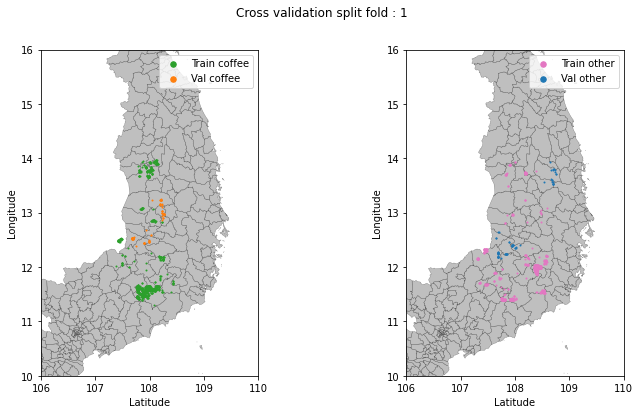

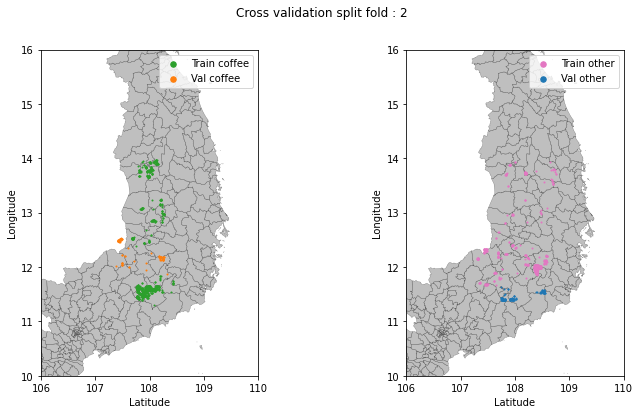

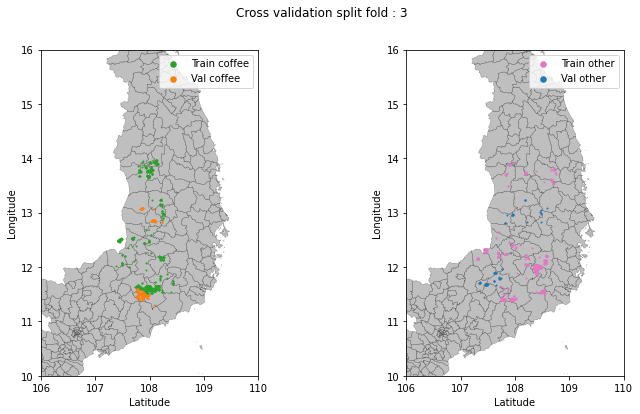

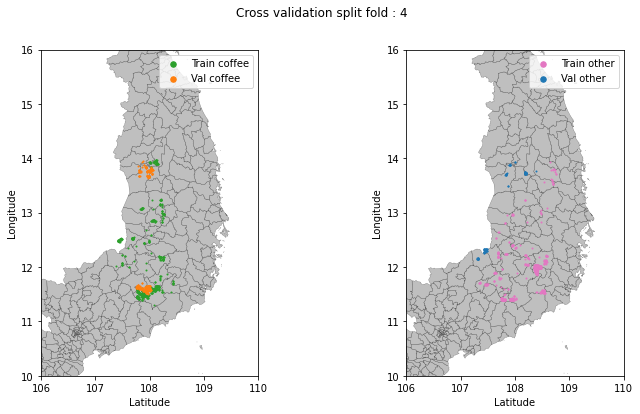

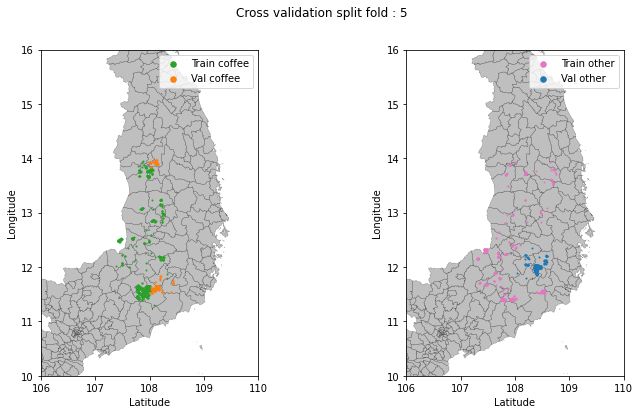

In [14]:
NB_FOLD = 5
for i_fold in range(0, NB_FOLD):
    geo_train = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","culture_10fold",f"train_{i_fold+1}_data.csv")))
    geo_train['geometry'] = geo_train['geometry'].apply(wkt.loads)
    
    geo_val = gpd.GeoDataFrame(pd.read_csv(os.path.join("datasets","culture_10fold",f"val_{i_fold+1}_data.csv")))
    geo_val['geometry'] = geo_val['geometry'].apply(wkt.loads)

    display_cross_val_map_class(geo_train, 
                                geo_val, 
                                vietnam, 
                                f"Cross validation split fold : {i_fold+1}",
                                legend1=["Train culture", "Val culture"],
                                legend2=["Train no-culture", "Val no-culture"])
    
    print(f"Fold {i_fold+1} Number culture - train : {len(geo_train[geo_train['label'] == 0])}")
    print(f"Fold {i_fold+1} Number no-culture - train : {len(geo_train[geo_train['label'] == 1])}")

    print(f"Fold {i_fold+1} Number culture - val : {len(geo_val[geo_val['label'] == 0 ])}")
    print(f"Fold {i_fold+1} Number no-culture - val : {len(geo_val[geo_val['label'] == 1])}")
    print(f"Training for fold {i_fold+1}")

    print("-----")
    
    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                        epochs=EPOCH,
                        steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                        validation_data=validation_generator,
                        validation_steps=len(geo_val)//BATCH_SIZE,
                        callbacks=[earlystopper])

    model.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(i_fold) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    results.append(result)

    print(f"Fold {i_fold+1} loss : {result[0]}")
    print(f"Fold {i_fold+1} accuracy : {result[1]}")
    print(f"Fold {i_fold+1} F1-score : {result[4]}")
    
    compute_score(geo_val, model)

    print("\n")

    K.clear_session()

### Fold score

In [15]:
losses, accs, precisions, recalls, f1_score = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean f1 : {np.mean(f1_score)}")
print(f"Stdev f1 : {np.std(f1_score)}")

Mean accuracy : 0.815625
Stdev accuracy : 0.07841352970390378


Mean loss : 0.546539843082428
Stdev loss : 0.14764486733318502


Mean precision : 0.7611283302307129
Stdev precision : 0.10856690928662373


Mean recall : 0.7146728038787842
Stdev recall : 0.18588687470253648


Mean f1 : 0.7268824934959411
Stdev f1 : 0.14045134374193116


In [16]:
with open(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

### Loss and accuracy per fold

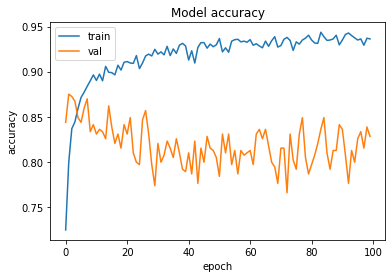

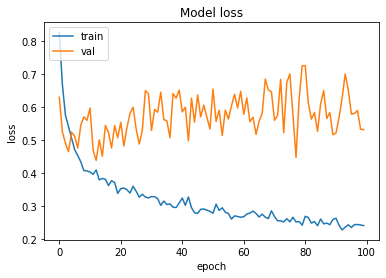

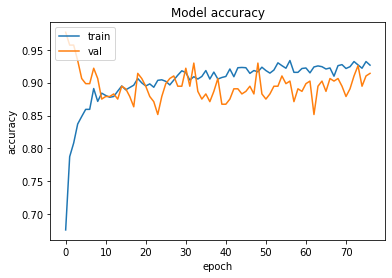

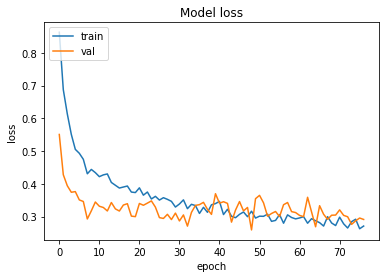

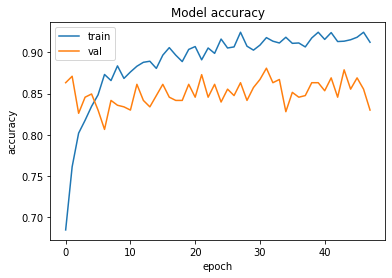

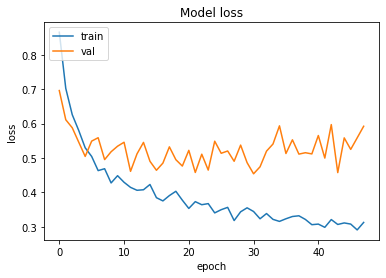

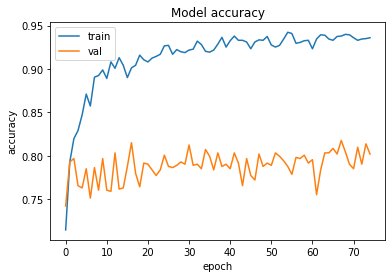

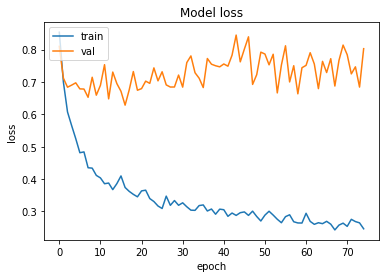

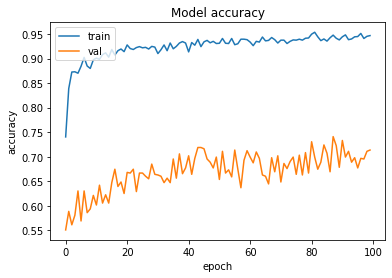

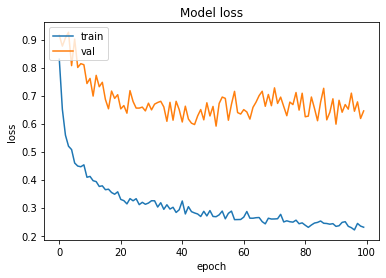

In [5]:
a = os.path.join(SAVED_MODELS_PATH, 'Culture', 'final_spacv_10FOLD_culture_ds2')
for i in os.listdir(a):
    if(i.split('.')[1] == 'npy'):
        chart = np.load(os.path.join(a, i), allow_pickle=True).item()
        
        # summarize history for accuracy
        plt.plot(chart['accuracy'])
        plt.plot(chart['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

        # summarize history for loss
        plt.plot(chart['loss'])
        plt.plot(chart['val_loss'])
        plt.title('Model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

## Stratified cross-val
### Train model

In [11]:
# Params
BATCH_SIZE = 64
EPOCH = 100
LEARNING_RATE = 0.0001
DATA_AUGMENTATION_MULTIPLIATOR = 2
RUN_NAME = 'strat_culture_1'
NB_FOLD = 5

if not os.path.exists(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME)):
    os.mkdir(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME))
    
METRICS = [
      metrics.BinaryAccuracy(name='accuracy'),
      metrics.Precision(name='precision'),
      metrics.Recall(name='recall')
]

In [12]:
from sklearn.model_selection import StratifiedKFold

fold_index = 0

results = []

skf = StratifiedKFold(n_splits=5)
for train, validation in skf.split(data_train['path'].to_numpy(), data_train['label'].to_numpy()):
    
    geo_train = data_train.iloc[train]
    geo_val = data_train.iloc[validation]
    
    train_generator = generator(geo_train['path'].to_numpy(), 
                                  geo_train['label'].to_numpy(), 
                                  eurosat_params['mean'], 
                                  eurosat_params['std'], 
                                  batch_size=BATCH_SIZE, 
                                  is_data_augmentation=True)

    validation_generator = generator(geo_val['path'].to_numpy(), 
                                geo_val['label'].to_numpy(), 
                                eurosat_params['mean'], 
                                eurosat_params['std'], 
                                batch_size=BATCH_SIZE)


    earlystopper = EarlyStopping(monitor='accuracy',patience=20,restore_best_weights=True)
      
    model = create_model()

    model.compile(optimizer=Adam(learning_rate=LEARNING_RATE), loss='binary_crossentropy',metrics=METRICS)

    history = model.fit(train_generator,
                                epochs=EPOCH,
                                steps_per_epoch=(len(geo_train)//BATCH_SIZE)*DATA_AUGMENTATION_MULTIPLIATOR,
                                validation_data=validation_generator,
                                validation_steps=len(geo_val)//BATCH_SIZE,
                                callbacks=[earlystopper])

    model.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.h5'))

    np.save(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + '_'+ str(fold_index) +'.npy'),history.history)
    
    result = model.evaluate(validation_generator,steps=4)
    result.append(2*((result[2]*result[3])/(result[2]+result[3])))
    results.append(result)
    
    print(f"Fold {fold_index} loss : {result[0]}")
    print(f"Fold {fold_index} accuracy : {result[1]}")
    print(f"Fold {fold_index} F1-score : {result[4]}")
    print("\n")

    K.clear_session()

    fold_index+=1

Epoch 1/100
36/36 [==============================] - 15s 207ms/step - loss: 0.9168 - accuracy: 0.6147 - precision: 0.5715 - recall: 0.7572 - val_loss: 0.6544 - val_accuracy: 0.8438 - val_precision: 0.9822 - val_recall: 0.6831
Epoch 2/100
36/36 [==============================] - 5s 140ms/step - loss: 0.6750 - accuracy: 0.8042 - precision: 0.8781 - recall: 0.6799 - val_loss: 0.5700 - val_accuracy: 0.8457 - val_precision: 0.9465 - val_recall: 0.7195
Epoch 3/100
36/36 [==============================] - 5s 139ms/step - loss: 0.5826 - accuracy: 0.8253 - precision: 0.8821 - recall: 0.7337 - val_loss: 0.5317 - val_accuracy: 0.8496 - val_precision: 0.9583 - val_recall: 0.6970
Epoch 4/100
36/36 [==============================] - 5s 137ms/step - loss: 0.5304 - accuracy: 0.8463 - precision: 0.9062 - recall: 0.7449 - val_loss: 0.4913 - val_accuracy: 0.8691 - val_precision: 0.9561 - val_recall: 0.7717
Epoch 5/100
36/36 [==============================] - 5s 140ms/step - loss: 0.4935 - accuracy: 0.862

36/36 [==============================] - 5s 145ms/step - loss: 0.4696 - accuracy: 0.8465 - precision: 0.8708 - recall: 0.7777 - val_loss: 0.3863 - val_accuracy: 0.8984 - val_precision: 0.9670 - val_recall: 0.8200
Epoch 10/100
36/36 [==============================] - 5s 143ms/step - loss: 0.4299 - accuracy: 0.8675 - precision: 0.9011 - recall: 0.8073 - val_loss: 0.4216 - val_accuracy: 0.8945 - val_precision: 0.9548 - val_recall: 0.7860
Epoch 11/100
36/36 [==============================] - 5s 146ms/step - loss: 0.3934 - accuracy: 0.8938 - precision: 0.9317 - recall: 0.8421 - val_loss: 0.3964 - val_accuracy: 0.8926 - val_precision: 0.9431 - val_recall: 0.8223
Epoch 12/100
36/36 [==============================] - 5s 142ms/step - loss: 0.4338 - accuracy: 0.8701 - precision: 0.8883 - recall: 0.8266 - val_loss: 0.4186 - val_accuracy: 0.8691 - val_precision: 0.9190 - val_recall: 0.7942
Epoch 13/100
36/36 [==============================] - 5s 143ms/step - loss: 0.4366 - accuracy: 0.8766 - preci

36/36 [==============================] - 5s 141ms/step - loss: 0.2772 - accuracy: 0.9272 - precision: 0.9426 - recall: 0.8938 - val_loss: 0.2687 - val_accuracy: 0.9297 - val_precision: 0.9649 - val_recall: 0.8871
Epoch 82/100
36/36 [==============================] - 5s 142ms/step - loss: 0.2630 - accuracy: 0.9224 - precision: 0.9299 - recall: 0.9022 - val_loss: 0.2906 - val_accuracy: 0.9199 - val_precision: 0.9415 - val_recall: 0.8694
Epoch 83/100
36/36 [==============================] - 5s 140ms/step - loss: 0.2618 - accuracy: 0.9316 - precision: 0.9520 - recall: 0.9079 - val_loss: 0.3157 - val_accuracy: 0.9043 - val_precision: 0.9283 - val_recall: 0.8625
Epoch 84/100
36/36 [==============================] - 5s 139ms/step - loss: 0.2722 - accuracy: 0.9262 - precision: 0.9384 - recall: 0.9003 - val_loss: 0.2677 - val_accuracy: 0.9277 - val_precision: 0.9469 - val_recall: 0.9062
Epoch 85/100
36/36 [==============================] - 5s 141ms/step - loss: 0.2490 - accuracy: 0.9340 - preci

36/36 [==============================] - 5s 139ms/step - loss: 0.2902 - accuracy: 0.9174 - precision: 0.9157 - recall: 0.9158 - val_loss: 0.2822 - val_accuracy: 0.9277 - val_precision: 0.9358 - val_recall: 0.8987
Epoch 53/100
36/36 [==============================] - 5s 139ms/step - loss: 0.2853 - accuracy: 0.9309 - precision: 0.9493 - recall: 0.9072 - val_loss: 0.2892 - val_accuracy: 0.9336 - val_precision: 0.9824 - val_recall: 0.8814
Epoch 54/100
36/36 [==============================] - 5s 139ms/step - loss: 0.2851 - accuracy: 0.9288 - precision: 0.9475 - recall: 0.9018 - val_loss: 0.2688 - val_accuracy: 0.9277 - val_precision: 0.9309 - val_recall: 0.9197
Epoch 55/100
36/36 [==============================] - 5s 140ms/step - loss: 0.3079 - accuracy: 0.9168 - precision: 0.9252 - recall: 0.8992 - val_loss: 0.2868 - val_accuracy: 0.9297 - val_precision: 0.9532 - val_recall: 0.8996
Epoch 56/100
36/36 [==============================] - 5s 140ms/step - loss: 0.2937 - accuracy: 0.9213 - preci

36/36 [==============================] - 5s 138ms/step - loss: 0.3123 - accuracy: 0.9228 - precision: 0.9366 - recall: 0.8917 - val_loss: 0.2884 - val_accuracy: 0.9238 - val_precision: 0.8920 - val_recall: 0.9489
Epoch 40/100
36/36 [==============================] - 5s 139ms/step - loss: 0.3126 - accuracy: 0.9136 - precision: 0.9186 - recall: 0.8893 - val_loss: 0.2844 - val_accuracy: 0.9238 - val_precision: 0.9053 - val_recall: 0.9322
Epoch 41/100
36/36 [==============================] - 5s 138ms/step - loss: 0.3312 - accuracy: 0.9072 - precision: 0.9126 - recall: 0.8715 - val_loss: 0.2957 - val_accuracy: 0.9043 - val_precision: 0.8806 - val_recall: 0.9328
Epoch 42/100
36/36 [==============================] - 5s 138ms/step - loss: 0.3357 - accuracy: 0.9020 - precision: 0.9160 - recall: 0.8737 - val_loss: 0.2965 - val_accuracy: 0.9121 - val_precision: 0.8953 - val_recall: 0.9277
Epoch 43/100
36/36 [==============================] - 5s 140ms/step - loss: 0.2912 - accuracy: 0.9337 - preci

36/36 [==============================] - 5s 139ms/step - loss: 0.3460 - accuracy: 0.9218 - precision: 0.9294 - recall: 0.9004 - val_loss: 0.3943 - val_accuracy: 0.8789 - val_precision: 0.8565 - val_recall: 0.8788
Epoch 20/100
36/36 [==============================] - 5s 139ms/step - loss: 0.3682 - accuracy: 0.9040 - precision: 0.9216 - recall: 0.8721 - val_loss: 0.3818 - val_accuracy: 0.8945 - val_precision: 0.9087 - val_recall: 0.8438
Epoch 21/100
36/36 [==============================] - 5s 136ms/step - loss: 0.3671 - accuracy: 0.9006 - precision: 0.9316 - recall: 0.8526 - val_loss: 0.4088 - val_accuracy: 0.8633 - val_precision: 0.8805 - val_recall: 0.8223
Epoch 22/100
36/36 [==============================] - 5s 138ms/step - loss: 0.3573 - accuracy: 0.8968 - precision: 0.9062 - recall: 0.8724 - val_loss: 0.3579 - val_accuracy: 0.9043 - val_precision: 0.9321 - val_recall: 0.8583
Epoch 23/100
36/36 [==============================] - 5s 140ms/step - loss: 0.3321 - accuracy: 0.9195 - preci

36/36 [==============================] - 5s 137ms/step - loss: 0.2469 - accuracy: 0.9387 - precision: 0.9700 - recall: 0.8974 - val_loss: 0.2920 - val_accuracy: 0.9277 - val_precision: 0.9378 - val_recall: 0.9113
Epoch 92/100
36/36 [==============================] - 5s 137ms/step - loss: 0.2522 - accuracy: 0.9351 - precision: 0.9540 - recall: 0.9085 - val_loss: 0.2703 - val_accuracy: 0.9414 - val_precision: 0.9651 - val_recall: 0.9095
Epoch 93/100
36/36 [==============================] - 5s 137ms/step - loss: 0.2580 - accuracy: 0.9243 - precision: 0.9408 - recall: 0.8981 - val_loss: 0.2701 - val_accuracy: 0.9277 - val_precision: 0.9414 - val_recall: 0.9073
Epoch 94/100
36/36 [==============================] - 5s 137ms/step - loss: 0.2492 - accuracy: 0.9342 - precision: 0.9467 - recall: 0.9144 - val_loss: 0.3196 - val_accuracy: 0.9180 - val_precision: 0.9518 - val_recall: 0.8750
Epoch 95/100
36/36 [==============================] - 5s 135ms/step - loss: 0.2556 - accuracy: 0.9324 - preci

### Fold scores

In [13]:
losses, accs, precisions, recalls, f1_scores = zip(*results)

print(f"Mean accuracy : {np.mean(accs)}")
print(f"Stdev accuracy : {np.std(accs)}")
print("\n")
print(f"Mean loss : {np.mean(losses)}")
print(f"Stdev loss : {np.std(losses)}")
print("\n")
print(f"Mean precision : {np.mean(precisions)}")
print(f"Stdev precision : {np.std(precisions)}")
print("\n")
print(f"Mean recall : {np.mean(recalls)}")
print(f"Stdev recall : {np.std(recalls)}")
print("\n")
print(f"Mean F1-Score : {np.mean(f1_scores)}")
print(f"Stdev F1-Score : {np.std(f1_scores)}")

Mean accuracy : 0.9265625
Stdev accuracy : 0.016646309181767592


Mean loss : 0.27794947624206545
Stdev loss : 0.027769519540595488


Mean precision : 0.9395267963409424
Stdev precision : 0.023373058774516606


Mean recall : 0.8953775048255921
Stdev recall : 0.03805134136252921


Mean F1-Score : 0.9162076730067013
Stdev F1-Score : 0.018911896167159256


In [14]:
with open(os.path.join(SAVED_MODELS_PATH, 'Culture', RUN_NAME, RUN_NAME + ".json"),'w') as fp:
    json.dump(results, fp)

### Loss and accuracy per fold

In [ ]:
a = os.path.join(SAVED_MODELS_PATH, 'Culture', 'strat_culture_1')
for i in os.listdir(a):
    if(i.split('.')[1] == 'npy'):
        chart = np.load(os.path.join(a, i), allow_pickle=True).item()
        
        # summarize history for accuracy
        plt.plot(chart['accuracy'])
        plt.plot(chart['val_accuracy'])
        plt.title('Model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()

        # summarize history for loss
        plt.plot(chart['loss'])
        plt.plot(chart['val_loss'])
        plt.title('Model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper left')
        plt.show()